In [1]:
#######################################
# TOV (High-Fidelity) Scaled Solver
# Author: Alexandra C. Semposki
# Last edited: 5 May 2025, by Joshua Maldonado
#######################################

import os
import numpy as np
import time
import matplotlib.pyplot as plt
plt.style.use("default")

from scipy.integrate import solve_ivp
from scipy.interpolate import interp1d


class TOVsolver:

    def __init__(self, eos_filepath=None, tidal=False, solver="RK4", solve_ivp_kwargs=None, sol_pts=4000):
        r"""
        Class to calculate the Tolman-Oppenheimer-Volkoff equations,
        including options for the tidal deformability and moment of
        inertia using RK4. Also includes uncertainty quantification
        techniques through the highest posterior density interval (HPD
        or HDI) calculation. Able to accept one EOS from a single curve
        or draws from an EOS, such as from a Gaussian Process.

        Example:
            tov = TOVSolver(eos_filepath='path/to/eos', tidal=True, moment=True)

        Parameters:
            eos_filepath (str): The path to the EOS data table to be used.

            tidal (bool): Whether to calculate tidal deformability or not.
                Default is False.

            moment (bool): Whether to calculate moment of inertia or not.
                Default is False.

        Returns:
            None.
        """

        # assign class variables
        self.tidal = tidal
        self.solver = solver
        self.sol_pts = sol_pts
        self.solve_ivp_kwargs = solve_ivp_kwargs  # this is only used in solve_ivp
        self.tol = 1e-9  # this is only used in solve_ivp

        # assign scaled variables
        self.eps0 = 1.285e3  # MeV fm-3
        self.pres0 = self.eps0
        self.mass0 = 2.837  # solar masses
        self.rad0 = 8.378  # km

        # load in the data (expects file with data headers for now)
        if eos_filepath is not None:

            file_name, self.eos_file_extension = os.path.splitext(eos_filepath)
            self.eos_name = (file_name.split("/"))[-1]

            # for data from compOSE
            if self.eos_file_extension == ".table":
                # extract from .table file
                self.eos_file = eos_filepath
                eos_data = np.loadtxt(eos_filepath)

                # check which column is which
                if eos_data.T[4][-1] < eos_data.T[3][-1]:
                    self.eps_array = eos_data.T[3] / self.eps0
                    self.pres_array = eos_data.T[4] / self.pres0
                else:
                    self.eps_array = eos_data.T[4] / self.eps0
                    self.pres_array = eos_data.T[3] / self.pres0

                self.nB_array = eos_data.T[1]

                if tidal is True:
                    dpdeps = np.gradient(self.pres_array, self.eps_array, edge_order=2)
                    self.cs2_array = dpdeps
                else:
                    self.cs2_array = np.zeros([len(self.pres_array)])

                # keep unscaled for use in density calculation
                self.pres_array_unscaled = eos_data.T[4]

            # For data generated by codes
            elif self.eos_file_extension == ".dat" or self.eos_file_extension == ".txt":

                # extract data and assign to arrays (assumes one sample/draw of EOS)
                self.eos_file = eos_filepath
                eos_data = np.loadtxt(eos_filepath)  # , skiprows=2)
                self.eps_array = eos_data.T[1] / self.eps0
                self.pres_array = eos_data.T[2] / self.pres0
                self.nB_array = eos_data.T[0]
                if len(eos_data[1]) > 3:
                    self.cs2_array = eos_data.T[3]
                else:
                    self.cs2_array = None

                # keep unscaled for use in density calculation
                self.pres_array_unscaled = eos_data.T[2]

            elif self.eos_file_extension == ".npz":

                self.eos_file = eos_filepath
                eos_data = np.load(eos_filepath)

                # assign to arrays based on header names
                self.eps_array = eos_data["edens"] / self.eps0
                self.pres_array = eos_data["pres"] / self.pres0
                self.nB_array = eos_data["density"]
                self.cs2_array = eos_data["cs2"]

            # print congrats
            print("Woo it worked!")

        else:
            raise ValueError("No file specified.")

        return None

    # include the RK4 handwritten solver
    def RK4(self, f, x0, t0, te, N):
        r"""
        A simple RK4 solver to avoid overhead of
        calculating with solve_ivp or any other
        adaptive step-size function.

        Example:
            tov.RK4(f=func, x0=1., t0=1., te=10., N=100)

        Parameters:
            f (func): A Python function for the ODE(s) to be solved.
                Able to solve N coupled ODEs.

            x0 (float): Guess for the function(s) to be solved.

            t0 (float): Initial point of the grid.

            te (float): End point of the grid.

            N (int): The number of steps to take in the range (te-t0).

        Returns:
            times (array): The grid of solution steps.

            solution (array): The solutions of each function
                at each point in the grid.
        """

        h = (te - t0) / N
        times = np.arange(t0, te + h, h)
        solution = []
        x = x0

        for t in times:
            solution.append(np.array(x).T)
            k1 = h * f(t, x)
            k2 = h * f(t + 0.5 * h, x + 0.5 * k1)
            k3 = h * f(t + 0.5 * h, x + 0.5 * k2)
            k4 = h * f(t + h, x + k3)
            x += (k1 + 2 * (k2 + k3) + k4) / 6

        solution = np.asarray(solution, dtype=np.float64).T

        return times, solution
    
    def RK2_midpoint(self, f, x0, t0, te, N):
        r"""
        A simple RK2 solver using the midpoint method.
        This is a low-fidelity solver.

        Example:
            tov.RK2(f=func, x0=1., t0=1., te=10., N=100)

        Parameters:
            f (func): A Python function for the ODE(s) to be solved.
                Able to solve N coupled ODEs.

            x0 (float): Guess for the function(s) to be solved.

            t0 (float): Initial point of the grid.

            te (float): End point of the grid.

            N (int): The number of steps to take in the range (te-t0).

        Returns:
            times (array): The grid of solution steps.

            solution (array): The solutions of each function
                at each point in the grid.
        """
        
        h = (te - t0) / N
        times = np.arange(t0, te + h, h)
        solution = []
        x = x0

        for t in times:
            solution.append(np.array(x).T)
            k1 = h * f(t, x)
            k2 = h * f(t + 0.5 * h, x + 0.5 * k1)
            x += k2

        solution = np.asarray(solution, dtype=np.float64).T

        return times, solution
    
    def RK2_Heun(self, f, x0, t0, te, N):
        r"""
        A simple RK2 solver using the Heun's method.
        This is a low-fidelity solver.

        Example:
            tov.RK2(f=func, x0=1., t0=1., te=10., N=100)

        Parameters:
            f (func): A Python function for the ODE(s) to be solved.
                Able to solve N coupled ODEs.

            x0 (float): Guess for the function(s) to be solved.

            t0 (float): Initial point of the grid.

            te (float): End point of the grid.

            N (int): The number of steps to take in the range (te-t0).

        Returns:
            times (array): The grid of solution steps.

            solution (array): The solutions of each function
                at each point in the grid.
        """
        
        h = (te - t0) / N
        times = np.arange(t0, te + h, h)
        solution = []
        x = x0
        
        for t in times:
            solution.append(np.array(x).T)
            k1 = f(t, x)
            k2 = f(t + h, x + k1 * h)
            x += h * (k1 + k2) * 0.5
        
        solution = np.asarray(solution, dtype=np.float64).T
        
        return times, solution
    
    def euler(self, f, x0, t0, te, N):
        r"""
        A simple forward euler solver to avoid overhead of
        calculating with solve_ivp or any other
        adaptive step-size function.
        This is a low fidelity solver!

        Example:
            tov.euler(f=func, x0=1., t0=1., te=10., N=100)

        Parameters:
            f (func): A Python function for the ODE(s) to be solved.
                Able to solve N coupled ODEs.

            x0 (float): Guess for the function(s) to be solved.

            t0 (float): Initial point of the grid.

            te (float): End point of the grid.

            N (int): The number of steps to take in the range (te-t0).

        Returns:
            times (array): The grid of solution steps.

            solution (array): The solutions of each function
                at each point in the grid.
        """
        
        h = (te - t0) / N
        times = np.arange(t0, te + h, h)
        solution = []
        x = x0

        for t in times:
            solution.append(np.array(x).T)
            x += h * f(t, x)
            
        solution = np.asarray(solution, dtype=np.float64).T

        return times, solution

    def tov_equations_scaled(self, x, y0):
        r"""
        The Tolman-Oppenheimer-Volkoff equations in scaled format, to be
        solved with the RK4 routine. If selected, the tidal deformability
        and moment of inertia will be included and solved
        simultaneously.

        Example:
            tov.tov_equations_scaled(x=0.2,
                y0=[m_init, p_init])

        Parameters:
            x (float): A point in the scaled radius grid.

            y0 (list): The list of initial guesses for each function
                solved.

        Returns:
            The solutions, in array format, of each function to be
                solved.
        """

        # unpack the initial conditions
        if self.tidal is True:
            pres, mass, y = y0
            cs2 = self.cs2_interp(pres)
        else:
            pres, mass = y0

        eps = self.eps_interp(pres)

        # must also receive monotonically increasing P(n) results
        if pres > 0.0:

            # pressure equation
            dpdx = (
                -0.5 * (pres + eps) * (mass + 3 * x**3.0 * pres) / (x**2.0 - x * mass)
            )

            # mass equation
            dmdx = 3.0 * x**2.0 * eps

            # tidal deformability equation
            if self.tidal is True:
                f = self.f_x(x, mass, pres, eps)
                q = self.q_x(x, mass, pres, eps, cs2)
                dydx = -(1.0 / x) * (y**2.0 + f * y + q)

        else:
            dpdx = 0.0
            dmdx = 0.0

            if self.tidal is True:
                dydx = 0.0

        if self.tidal is True:
            return np.array([dpdx, dmdx, dydx], dtype=np.float64)

        return np.array([dpdx, dmdx], dtype=np.float64)

    def f_x(self, x, mass, pres, eps):
        r"""
        A function in the tidal deformability calculation.

        Example:
            tov.f_x(x=0.2, mass=1.06, pres=2.34, eps=6.0)

        Parameters:
            x (float): The current gridpoint in scaled radius.

            mass (float): The current mass.

            pres (float): The current pressure from the EOS.

            eps (float): The current energy density from the EOS.

        Returns:
            The value of F(x) at the current radius.
        """

        one = 1.0 - (3.0 / 2.0) * (eps - pres) * x**2.0
        two = 1.0 - mass / x
        return one / two

    def q_x(self, x, mass, pres, eps, cs2):
        r"""
        A function in the calculation of the tidal deformability.

        Example:
            tov.q_x(x=0.1, mass=2.0, pres=1.0, eps=3.0, cs2=0.33)

        Parameters:
            x (float): The current gridpoint in scaled radius.

            mass (float): The current mass.

            pres (float): The current pressure from the EOS.

            eps (float): The current energy density from the EOS.

            cs2 (float): The current speed of sound from the EOS.

        Returns:
            The value of Q(x) at the current radius.
        """
        pre = (3.0 / 2.0) * x**2.0 / (1.0 - mass / x)
        one = 5.0 * eps + 9.0 * pres + ((eps + pres) / cs2) - (4.0 / x**2.0)
        two = (mass / x) + 3.0 * x**2.0 * pres
        three = 1.0 - mass / x
        return pre * one - (two / three) ** 2.0

    # love number equations and tidal deformability
    def tidal_def(self, yR, mass, radius):
        r"""
        The calculation of the tidal deformability, Lambda, and
        the tidal Love number, k2. This function is calculated after
        the RK4 routine has been completed.

        Example:
            tov.tidal_def(yR=np.array, mass=np.array, radius=np.array)

        Parameters:
            yR (float): The array of y at the maximum radii points.

            mass (float): The array of mass at the maximum radii.

            radius (float): The maximum radii array.

        Returns:
            tidal_deform (array): The tidal deformability solved at
                each point in the maximum radius.

            k2 (array): The value of the Love number calculated at the
                compactness M/R and the value of y at maximum radius.
        """

        # love number calculation
        beta = (mass / radius) * (self.rad0 / (2.0 * self.mass0))
        k2 = (
            (8.0 / 5.0)
            * beta**5.0
            * (1.0 - 2.0 * beta) ** 2.0
            * (2.0 - yR + 2.0 * beta * (yR - 1.0))
            * (
                2.0 * beta * (6.0 - 3.0 * yR + 3.0 * beta * (5.0 * yR - 8.0))
                + 4.0
                * beta**3.0
                * (
                    13.0
                    - 11.0 * yR
                    + beta * (3.0 * yR - 2.0)
                    + 2.0 * beta**2.0 * (1.0 + yR)
                )
                + 3.0
                * (1.0 - 2.0 * beta) ** 2.0
                * (2.0 - yR + 2.0 * beta * (yR - 1.0))
                * np.log(1.0 - 2.0 * beta)
            )
            ** (-1.0)
        )

        # tidal deformability calculation
        tidal_deform = (2.0 / 3.0) * k2 * (2.0 * self.mass0 * radius / (self.rad0 * mass))**5.0

        return tidal_deform, k2

    def tov_routine(self, verbose=False, write_to_file=False):
        r"""
        The TOV routine to solve each set of coupled ODEs and to output
        the quantities needed to display the M-R curve, as well as the
        tidal deformability and moment of inertia if desired.

        Example:
            tov.tov_routine(verbose=True, write_to_file=True)

        Parameters:
            verbose (bool): Whether to plot quantities and display
                the full maximum mass array. Default is False.

            write_to_file (bool): Choice to write the TOV results to
                a file located in a folder of the user's choice.
                Default is False.

        Returns:
            self.total_radius (array): The array of total maximum
                radius values.

            self.total_pres_central (array): The array of total
                central pressure values.

            self.total_max_mass (array): The array of total
                maximum mass values.
        """

        # initial pressure
        pres_init = min(2.0, max(self.pres_array))
        mass_init = 0.0

        if self.tidal is True:
            y_init = 2.0

        # set initial radius array
        low_pres = max(1e-3, min(self.pres_array))
        x = np.geomspace(1e-8, 2.5, 50)
        pres_space = np.geomspace(low_pres, pres_init, len(x))

        if self.tidal is True:
            self.yR = np.zeros(len(x))

        # set up arrays for the final results
        self.total_mass = np.zeros(len(x))
        self.total_radius = np.zeros(len(x))
        self.total_pres_central = np.zeros(len(x))

        # set up arrays (impermanent so this will work)
        max_mass = np.zeros(len(x))
        pres_central = np.zeros(len(x))
        max_radius = np.zeros(len(x))

        # interpolate the energy density
        self.eps_interp = interp1d(
            self.pres_array,
            self.eps_array,
            axis=0,
            kind="linear",
            fill_value="extrapolate",
        )

        if self.tidal is True:
            self.cs2_interp = interp1d(
                self.pres_array,
                self.cs2_array,
                axis=0,
                kind="linear",
                fill_value="extrapolate",
            )

        # loop over the TOV equations
        for i in range(len(x)):
            init_guess = []
            # initial conditions
            mass_arg = mass_init
            pres_arg = pres_space[i]
            init_guess.append(pres_arg)
            init_guess.append(mass_arg)

            if self.tidal is True:
                y_arg = y_init
                init_guess.append(y_arg)

            # Improve init_guess as one entry for all solutions
            # high fidelity (four function evals per sol_pt)
            if self.solver == "RK4":
                xval, sol = self.RK4(self.tov_equations_scaled, init_guess, 1e-3, 4.0, self.sol_pts)
            
            # low fidelity (two function evals per sol_pt)
            elif (self.solver == "RK2_midpoint") or (self.solver == "RK2 midpoint"):
                xval, sol = self.RK2_midpoint(self.tov_equations_scaled, init_guess, 1e-3, 4.0, self.sol_pts)
            
            elif (self.solver == "RK2_Heun") or (self.solver == "RK2 Heun"):
                xval, sol = self.RK2_Heun(self.tov_equations_scaled, init_guess, 1e-3, 4.0, self.sol_pts)
            
            # low fidelity (one function eval per sol_pt)
            elif self.solver == "euler":
                xval, sol = self.euler(self.tov_equations_scaled, init_guess, 1e-3, 4.0, self.sol_pts)
            
            # adaptive (typically high fidelity)
            elif self.solver == "solve_ivp":
                if self.solve_ivp_kwargs is None:
                    self.solve_ivp_kwargs = {"method": "RK45",
                                             "atol": 5e-14,
                                             "rtol": self.tol,
                                             "max_step": 0.01,
                                             "dense_output": True}
                if self.tidal is True:
                    sol = solve_ivp(
                        self.tov_equations_scaled,
                        [1e-3, 2.5],
                        [pres_arg, mass_arg, y_arg],
                        **self.solve_ivp_kwargs
                    )
                else:
                    sol = solve_ivp(
                        self.tov_equations_scaled,
                        [1e-8, 2.5],
                        [pres_arg, mass_arg],
                        **self.solve_ivp_kwargs
                    )
                if not sol.success:
                    print("Solver failed.")
                    print(sol.message)
                xval = sol.t
                sol = sol.y
            else:
                assert ValueError(f"Solver, {self.solver} unknown. Must be \"RK4\", \"RK2\" or \"euler\".")

            # maximum mass
            index_mass = np.where([sol[0] > 1e-10])[1][-1]
            max_mass[i] = sol[1, index_mass]

            # central pressure
            pres_central[i] = np.max(sol[0])

            # maximum radius
            max_radius[i] = xval[index_mass]

            if self.tidal is True:
                self.yR[i] = sol[2][index_mass]

        # scale results (send back totals at the end using these)
        max_mass = max_mass * self.mass0
        max_radius = max_radius * self.rad0
        pres_central = pres_central * self.pres0
        self.total_mass = max_mass
        self.total_radius = max_radius
        self.total_pres_central = pres_central
        # max mass calculation, radius, and central pressure
        self.maximum_mass = np.max(max_mass)
        corr_radius_index = np.where(max_mass == self.maximum_mass)[0][0]
        self.corr_radius = max_radius[corr_radius_index]
        self.corr_pres = pres_central[corr_radius_index]

        # save these results
        self.max_mass_arr = self.maximum_mass
        self.max_radius_arr = self.corr_radius
        self.max_pres_arr = self.corr_pres

        print(
            "Max mass: ",
            self.maximum_mass,
            "Radius: ",
            self.corr_radius,
            "Central pressure: ",
            self.corr_pres,
        )

        # tidal deformability
        if self.tidal is True:
            self.tidal_deformability, self.k2 = self.tidal_def(
                self.yR, max_mass, max_radius
            )
            # print(
            # "Tidal deformability at all points: {}".format(self.tidal_deformability)
            # )
            # print("k2 at all points: {}".format(self.k2))
        
        print("\n\n")
        print("radius")
        print(list(max_radius))
        print("")
        print("mass")
        print(list(max_mass))
        print("")
        print("pressure")
        print(list(pres_central))
        print("")
        print("k2")
        print(list(self.k2))
        print("\n\n")

        if verbose is True:
            print("Max mass array: ", max_mass)

            # plot stuff
            plt.plot(max_radius, max_mass, label=r"TOV")
            # plt.plot(dense_rad, mrad_arr, label=r'Interpolant')
            plt.xlabel("Radius [km]")
            plt.ylabel("Max Mass [M_solar]")
            plt.legend()
            plt.show()
            plt.plot(max_radius, pres_central)
            plt.xlabel("Radius [km]")
            plt.ylabel("Central pressure [MeV/fm^3]")
            plt.show()

            if self.tidal is True:
                plt.plot(max_mass / max_radius, self.yR)
                plt.xlabel(r"$\beta$")
                plt.ylabel(r"y(r)")
                plt.savefig("yr_scaled.png")
                plt.show()
                # fig = plt.figure(figsize=(8,6), dpi=200)
                plt.plot(max_radius, self.tidal_deformability, color="k")
                plt.xlabel("Radius", fontsize=14)
                plt.ylabel(r"$\Lambda(R)$", fontsize=14)
                plt.xticks(fontsize=12)
                plt.yticks(fontsize=12)
                plt.savefig("tidal.png")
                plt.show()
                # fig = plt.figure(figsize=(8,6), dpi=200)
                plt.plot(max_mass, self.tidal_deformability, color="k")
                plt.xlabel(r"Mass [$M_{\odot}$]", fontsize=14)
                plt.ylabel(r"$\Lambda(M)$", fontsize=14)
                plt.xticks(fontsize=12)
                plt.yticks(fontsize=12)
                plt.savefig("tidal_mass.png")
                plt.show()
                # fig = plt.figure(figsize=(8,6), dpi=200)
                plt.plot(max_mass / max_radius, self.k2, color="k")
                plt.xticks(fontsize=12)
                plt.yticks(fontsize=12)
                plt.xlabel(r"$\beta$", fontsize=14)
                plt.ylabel(r"$k_{2}(\beta)$", fontsize=14)
                plt.savefig("k2.png")
                plt.show()
                # fig = plt.figure(figsize=(8,6), dpi=200)
                plt.plot(max_radius, self.k2, color="k")
                plt.xticks(fontsize=12)
                plt.yticks(fontsize=12)
                plt.xlabel(r"$R$ [km]", fontsize=14)
                plt.ylabel(r"$k_{2}(R)$", fontsize=14)
                plt.xlim(9.0, 15.0)
                plt.savefig("k2R.png")
                plt.show()

            # check the solution
            print(
                "Radius: ",
                self.corr_radius,
                "Maximum mass: ",
                self.maximum_mass,
                "Central pressure: ",
                self.corr_pres,
            )

        # if desired, write to a file
        if write_to_file is True:
            tov_data = np.column_stack(
                [self.total_radius, self.total_mass, self.total_pres_central]
            )
            file_name = "TOV_data/rpm_results" + "_" + self.eos_name + ".dat"
            header = "Radius[km] Mass[Msol] Central_Pressure[MeV/fm3]"
            np.savetxt(file_name, tov_data, header=header, delimiter=" ")

        return self.total_radius, self.total_pres_central, self.total_mass
    

    def max_arrays(self):
        r'''
        Returns the max arrays needed for the interval calculation.

        Parameters:
            None.

        Returns:
            self.max_radius_arr (array): Maximum radius array.
            self.max_pres_arr (array): Maximum central pressure array.
            self.max_mass_arr (array): Maximum mass array.
        '''
        return self.max_radius_arr, self.max_pres_arr, self.max_mass_arr


    def central_dens(self, pres_arr=None):
        r"""
        Calculation to determine the central density of the star
        at the maximum mass and radius determined from the tov_routine().

        Example:
            tov.central_dens()

        Parameters:
            pres_arr (array): An optional pressure array to use for
                calculating central densities at places other
                than the absolute TOV maximum mass of each curve.
                Default is None, and code will use absolute TOV
                maximum mass central pressure class array.

        Returns:
            c_dens (array): The array of central densities for
                each EOS used.
        """

        # interpolate the EOS to find the proper central densities
        p_n_interp = interp1d(
            self.pres_array_unscaled,
            self.nB_array,
            kind="cubic",
            fill_value="extrapolate",
        )

        # solve at the proper central pressure for nB_central
        c_dens = p_n_interp(self.corr_pres)

        return c_dens


    def canonical_NS_radius(self):
        r"""
        Calculation of the radius of a 1.4 M_sol neutron star.

        Example:
            tov.canonical_NS_radius()

        Parameters:
            None.

        Returns:
            rad_14 (array): The array of values of the radius
                for each EOS used.
        """

        # interpolate the mass radius result?
        m_r_interp = interp1d(
            self.total_mass,
            self.total_radius,
            kind="linear",
            fill_value="extrapolate",
        )
        return m_r_interp(1.4)


def main():

    filePath = os.getcwd().strip('src')
    eosName = "sorted_Sly4.dat"
    fileName = filePath + "/EOS_Data/" + eosName

    print(filePath + '/EOS_Data/')

    tov = TOVsolver(fileName, tidal=True)
    tov.tov_routine(verbose=True, write_to_file=True)


In [2]:
filePath = os.getcwd().strip('src')
eosName = "sorted_Sly4.dat"
fileName = filePath + "/EOS_Data/" + eosName

print(filePath + '/EOS_Data/')

/Users/joshuamaldonado/Documents/GitHub/SLM/EOS_Data/


Woo it worked!
Max mass:  2.0671529454228352 Radius:  10.109720032999997 Central pressure:  820.9659111615389



radius
[np.float64(25.705656073999993), np.float64(22.539563794999996), np.float64(20.177558443999995), np.float64(18.410242383499995), np.float64(17.061721597999995), np.float64(15.972853882999997), np.float64(15.101759710999996), np.float64(14.414935459999997), np.float64(13.870501602499997), np.float64(13.451706327499998), np.float64(13.099918296499997), np.float64(12.823513414999997), np.float64(12.597363966499998), np.float64(12.429845856499998), np.float64(12.295831368499996), np.float64(12.195320502499998), np.float64(12.111561447499998), np.float64(12.061306014499998), np.float64(12.019426486999997), np.float64(11.985922864999997), np.float64(11.960795148499997), np.float64(11.944043337499997), np.float64(11.935667431999997), np.float64(11.918915620999996), np.float64(11.910539715499997), np.float64(11.893787904499996), np.float64(11.868660187999996), np.float64(11.8

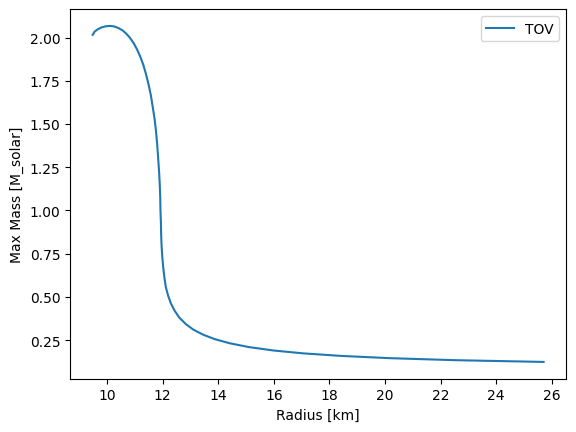

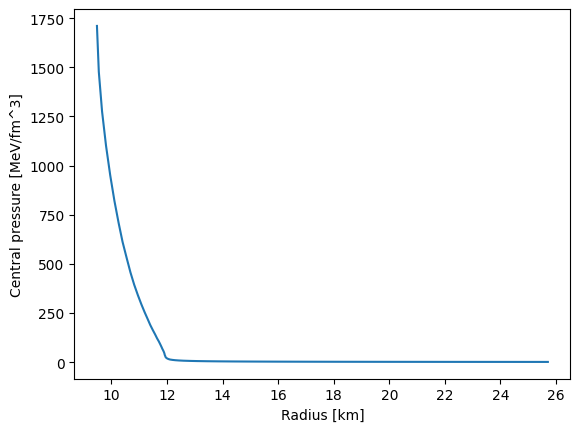

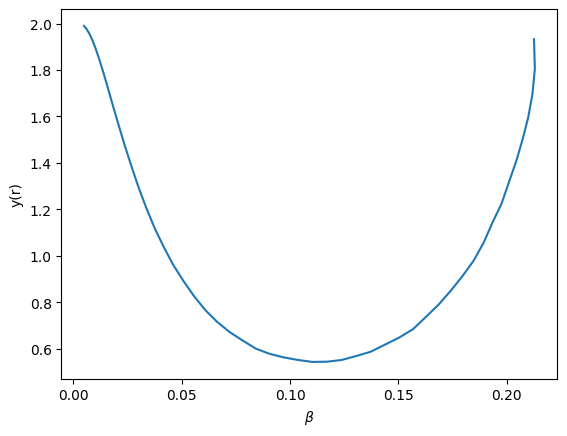

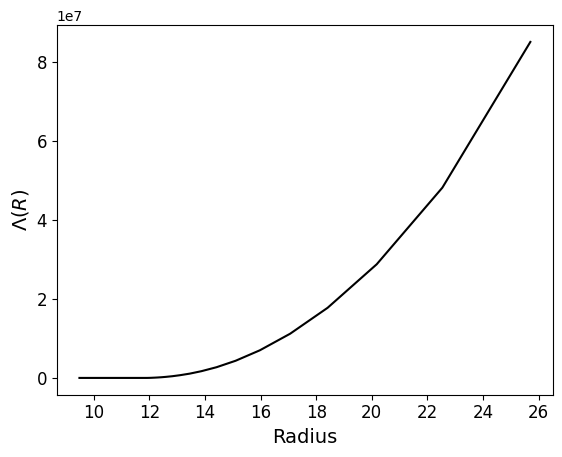

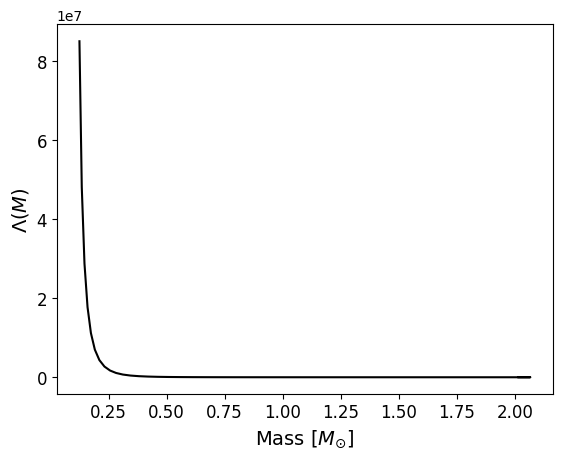

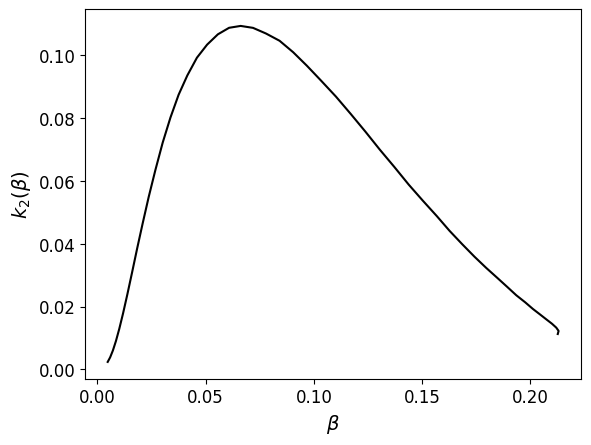

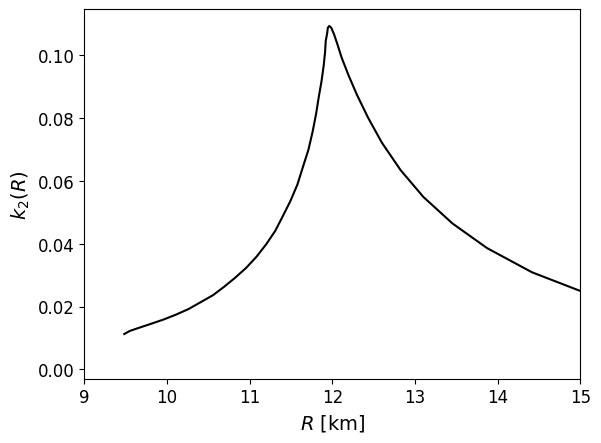

Radius:  10.109720032999997 Maximum mass:  2.0671529454228352 Central pressure:  820.9659111615389


(array([25.70565607, 22.53956379, 20.17755844, 18.41024238, 17.0617216 ,
        15.97285388, 15.10175971, 14.41493546, 13.8705016 , 13.45170633,
        13.0999183 , 12.82351341, 12.59736397, 12.42984586, 12.29583137,
        12.1953205 , 12.11156145, 12.06130601, 12.01942649, 11.98592286,
        11.96079515, 11.94404334, 11.93566743, 11.91891562, 11.91053972,
        11.8937879 , 11.86866019, 11.83515657, 11.80165294, 11.75977342,
        11.70951798, 11.64251074, 11.5755035 , 11.49174444, 11.39960948,
        11.30747452, 11.19858775, 11.08132507, 10.95568649, 10.821672  ,
        10.68765751, 10.55364302, 10.40287673, 10.26048633, 10.10972003,
         9.95895373,  9.80818743,  9.66579704,  9.54853436,  9.48152712]),
 array([1.28500000e+00, 1.48820486e+00, 1.72354374e+00, 1.99609819e+00,
        2.31175333e+00, 2.67732493e+00, 3.10070659e+00, 3.59104017e+00,
        4.15891318e+00, 4.81658740e+00, 5.57826364e+00, 6.46038837e+00,
        7.48200885e+00, 8.66518439e+00, 1.00354627e+

In [3]:
tov_midpoint = TOVsolver(fileName, tidal=True, solver="RK2_midpoint")
tov_midpoint.tov_routine(verbose=True, write_to_file=True)

Woo it worked!
Max mass:  2.067152672091504 Radius:  10.109720032999997 Central pressure:  820.9659111615389



radius
[np.float64(25.705656073999993), np.float64(22.539563794999996), np.float64(20.177558443999995), np.float64(18.410242383499995), np.float64(17.061721597999995), np.float64(15.972853882999997), np.float64(15.101759710999996), np.float64(14.414935459999997), np.float64(13.870501602499997), np.float64(13.451706327499998), np.float64(13.099918296499997), np.float64(12.823513414999997), np.float64(12.597363966499998), np.float64(12.429845856499998), np.float64(12.295831368499996), np.float64(12.195320502499998), np.float64(12.111561447499998), np.float64(12.061306014499998), np.float64(12.019426486999997), np.float64(11.985922864999997), np.float64(11.969171053999997), np.float64(11.944043337499997), np.float64(11.935667431999997), np.float64(11.927291526499998), np.float64(11.910539715499997), np.float64(11.893787904499996), np.float64(11.868660187999996), np.float64(11.83

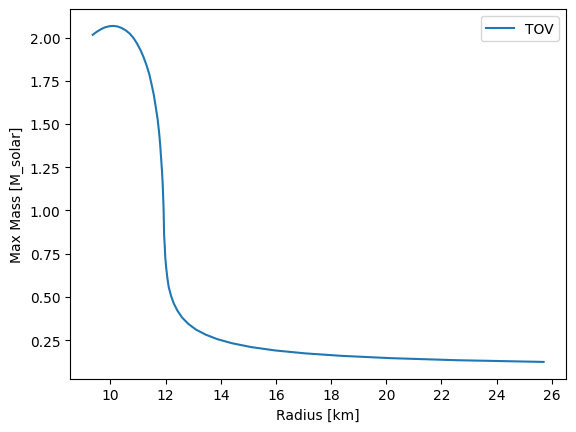

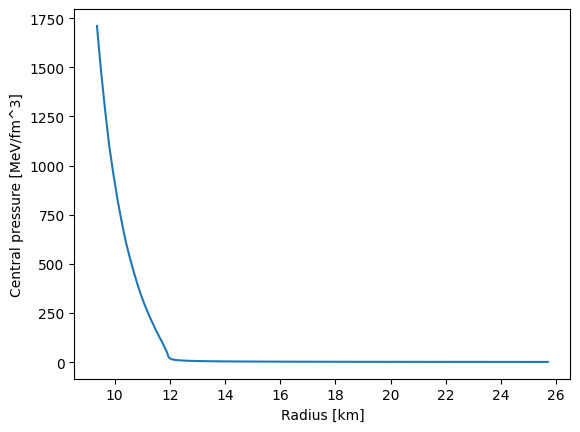

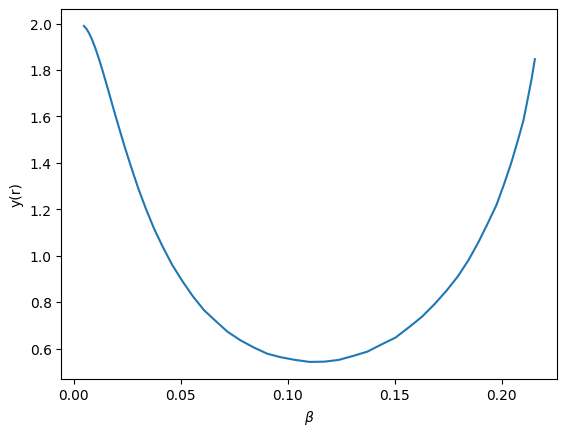

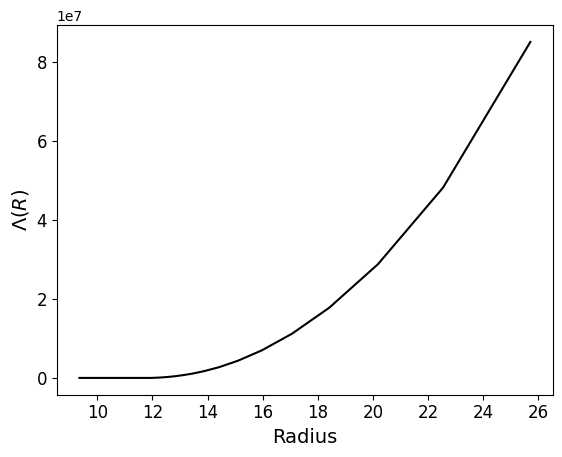

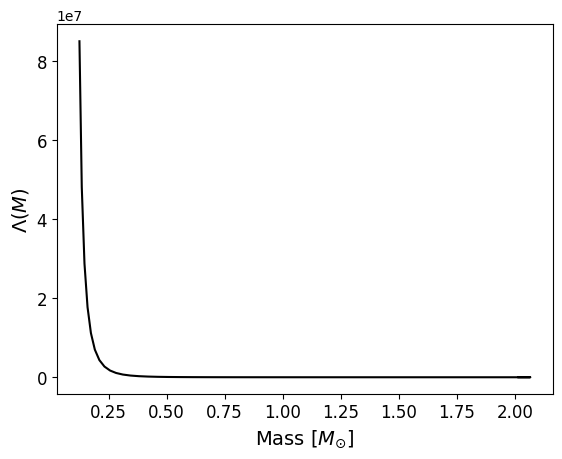

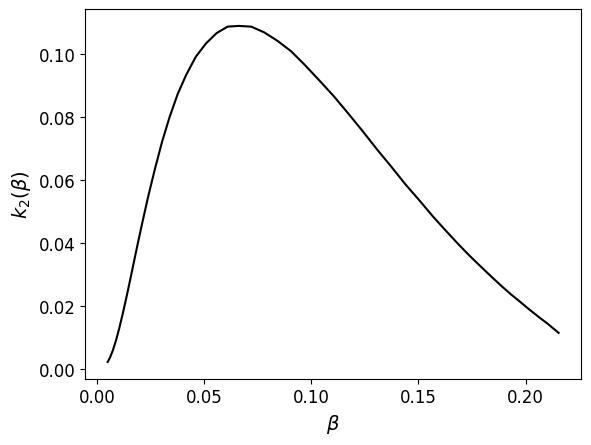

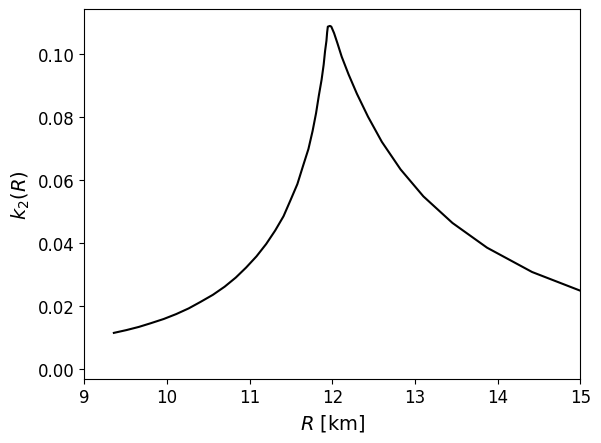

Radius:  10.109720032999997 Maximum mass:  2.067152672091504 Central pressure:  820.9659111615389


(array([25.70565607, 22.53956379, 20.17755844, 18.41024238, 17.0617216 ,
        15.97285388, 15.10175971, 14.41493546, 13.8705016 , 13.45170633,
        13.0999183 , 12.82351341, 12.59736397, 12.42984586, 12.29583137,
        12.1953205 , 12.11156145, 12.06130601, 12.01942649, 11.98592286,
        11.96917105, 11.94404334, 11.93566743, 11.92729153, 11.91053972,
        11.8937879 , 11.86866019, 11.83515657, 11.80165294, 11.75977342,
        11.70951798, 11.64251074, 11.5755035 , 11.49174444, 11.40798539,
        11.30747452, 11.19858775, 11.08132507, 10.95568649, 10.83004791,
        10.69603342, 10.55364302, 10.40287673, 10.26048633, 10.10972003,
         9.95895373,  9.79981153,  9.65742114,  9.50665484,  9.35588854]),
 array([1.28500000e+00, 1.48820486e+00, 1.72354374e+00, 1.99609819e+00,
        2.31175333e+00, 2.67732493e+00, 3.10070659e+00, 3.59104017e+00,
        4.15891318e+00, 4.81658740e+00, 5.57826364e+00, 6.46038837e+00,
        7.48200885e+00, 8.66518439e+00, 1.00354627e+

In [4]:
tov_heun = TOVsolver(fileName, tidal=True, solver="RK2_Heun")
tov_heun.tov_routine(verbose=True, write_to_file=True)

In [ ]:
print(len(tov_midpoint.total_mass), tov_midpoint.total_mass)
print(len(tov_midpoint.total_radius), tov_midpoint.total_radius)
print(len(tov_midpoint.total_pres_central), tov_midpoint.total_pres_central)
print(len(tov_midpoint.k2), tov_midpoint.k2)

50 [0.12442629 0.13442794 0.14610401 0.15927911 0.17383328 0.19074475
 0.21024412 0.23216249 0.25623283 0.28216254 0.31134561 0.34434591
 0.38081544 0.42026094 0.46205856 0.50726007 0.55744434 0.61189093
 0.66967149 0.72969801 0.79196073 0.85908146 0.93005371 1.00335704
 1.07735244 1.15098225 1.22700919 1.30457919 1.38176784 1.45666698
 1.52777148 1.59724067 1.66476511 1.72864363 1.78732498 1.83964473
 1.88709274 1.92994439 1.96729917 1.99840696 2.02282611 2.0415933
 2.05529204 2.06382561 2.06715295 2.06537497 2.05893244 2.04827093
 2.03375753 2.01578969]
50 [25.70565607 22.53956379 20.17755844 18.41024238 17.0617216  15.97285388
 15.10175971 14.41493546 13.8705016  13.45170633 13.0999183  12.82351341
 12.59736397 12.42984586 12.29583137 12.1953205  12.11156145 12.06130601
 12.01942649 11.98592286 11.96079515 11.94404334 11.93566743 11.91891562
 11.91053972 11.8937879  11.86866019 11.83515657 11.80165294 11.75977342
 11.70951798 11.64251074 11.5755035  11.49174444 11.39960948 11.307474

Woo it worked!
Max mass:  2.067149422218471 Radius:  10.093298176713457 Central pressure:  820.9659111615389



radius
[np.float64(20.945), np.float64(20.945), np.float64(19.98838129868016), np.float64(18.355673810707287), np.float64(16.967163310841872), np.float64(15.95695159370909), np.float64(15.09445436418899), np.float64(14.35133696247891), np.float64(13.868313054713305), np.float64(13.442188375148785), np.float64(13.072618379678175), np.float64(12.791457166475812), np.float64(12.58549822722303), np.float64(12.420924229213602), np.float64(12.279537039205225), np.float64(12.17679091645537), np.float64(12.098109268302617), np.float64(12.056495698273336), np.float64(12.005540378119036), np.float64(11.976909077082784), np.float64(11.95788077130876), np.float64(11.938975532563909), np.float64(11.926943527373163), np.float64(11.923579095949401), np.float64(11.904619651482019), np.float64(11.883603335165308), np.float64(11.86398951585778), np.float64(11.83025981598774), np.float64(11.799

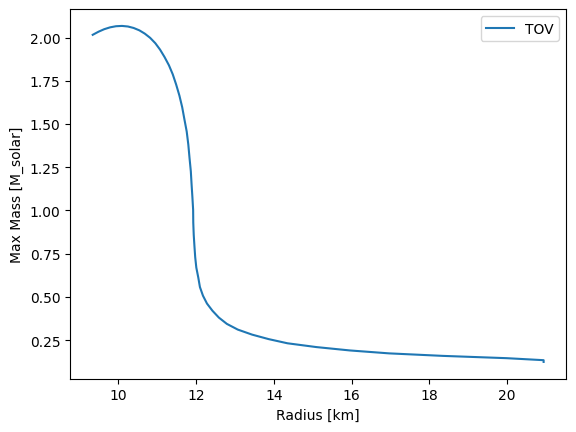

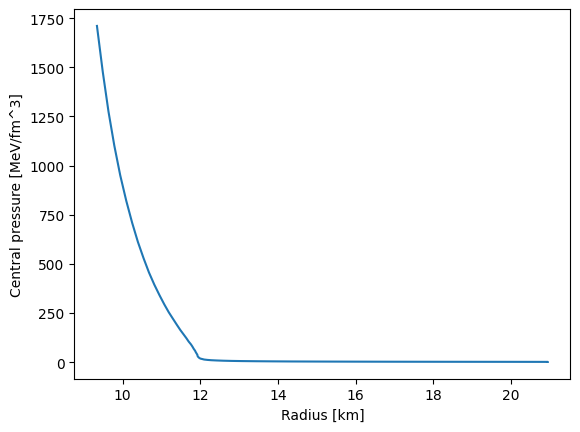

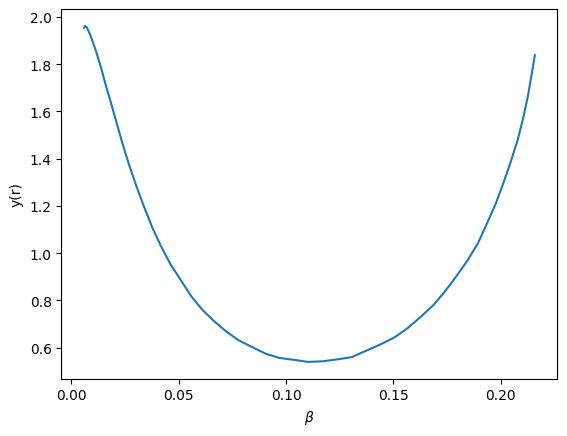

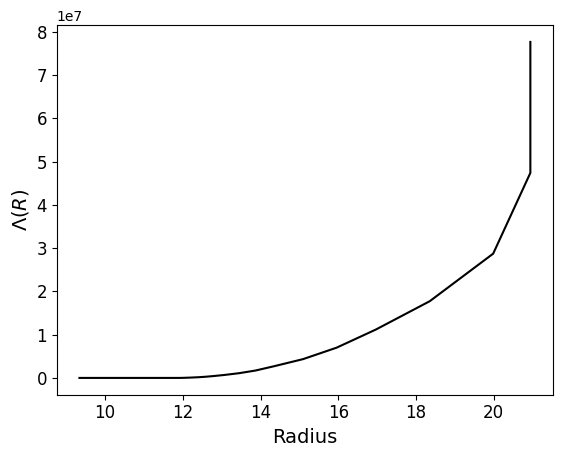

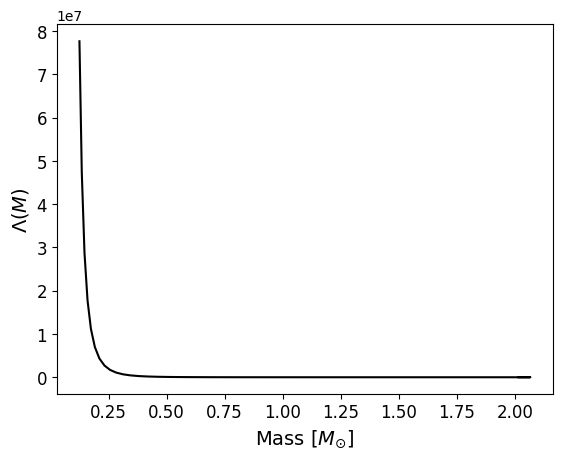

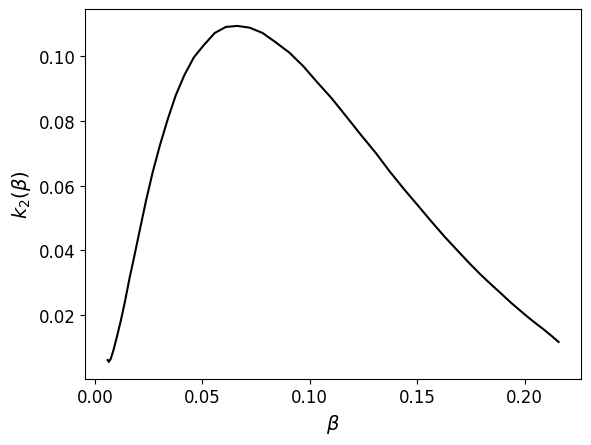

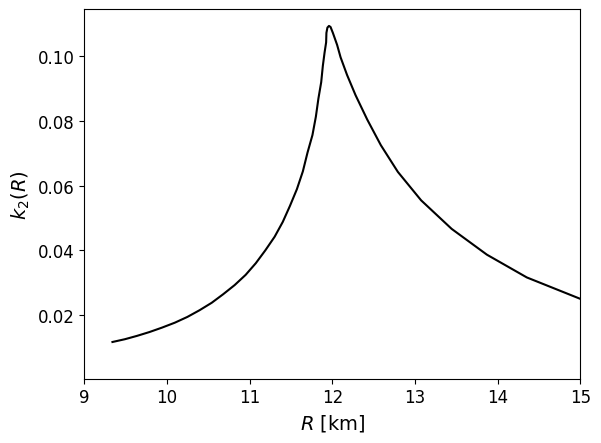

Radius:  10.093298176713457 Maximum mass:  2.067149422218471 Central pressure:  820.9659111615389


(array([20.945     , 20.945     , 19.9883813 , 18.35567381, 16.96716331,
        15.95695159, 15.09445436, 14.35133696, 13.86831305, 13.44218838,
        13.07261838, 12.79145717, 12.58549823, 12.42092423, 12.27953704,
        12.17679092, 12.09810927, 12.0564957 , 12.00554038, 11.97690908,
        11.95788077, 11.93897553, 11.92694353, 11.9235791 , 11.90461965,
        11.88360334, 11.86398952, 11.83025982, 11.79923676, 11.7580315 ,
        11.69843257, 11.64181633, 11.56983647, 11.48596639, 11.39881418,
        11.30071482, 11.18811636, 11.07277944, 10.949822  , 10.81638245,
        10.67757104, 10.53941318, 10.39217966, 10.24517435, 10.09329818,
         9.93782795,  9.78624052,  9.63543781,  9.48858969,  9.33882793]),
 array([1.28500000e+00, 1.48820486e+00, 1.72354374e+00, 1.99609819e+00,
        2.31175333e+00, 2.67732493e+00, 3.10070659e+00, 3.59104017e+00,
        4.15891318e+00, 4.81658740e+00, 5.57826364e+00, 6.46038837e+00,
        7.48200885e+00, 8.66518439e+00, 1.00354627e+

In [28]:
solve_ivp_kwargs = {"method": "RK45",  #"method": "Radau",
                    "atol": 1e-9,
                    "rtol": 1e-9,
                    "dense_output": True}

tov_exact = TOVsolver(fileName, tidal=True, solver="solve_ivp", solve_ivp_kwargs=solve_ivp_kwargs)
tov_exact.tov_routine(verbose=True, write_to_file=True)

In [29]:
exact_M = tov_exact.total_mass
midpoint_M = tov_midpoint.total_mass
Heun_M = tov_heun.total_mass

exact_R = tov_exact.total_radius
midpoint_R = tov_midpoint.total_radius
Heun_R = tov_heun.total_radius

exact_P = tov_exact.total_pres_central
midpoint_P = tov_midpoint.total_pres_central
Heun_P = tov_heun.total_pres_central

exact_k2 = tov_exact.k2
midpoint_k2 = tov_midpoint.k2
Heun_k2 = tov_heun.k2

/var/folders/58/xrmpvhh11mj0pb2kfrznw9qh0000gn/T/ipykernel_85737/2391416843.py:13: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()
/var/folders/58/xrmpvhh11mj0pb2kfrznw9qh0000gn/T/ipykernel_85737/2391416843.py:23: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


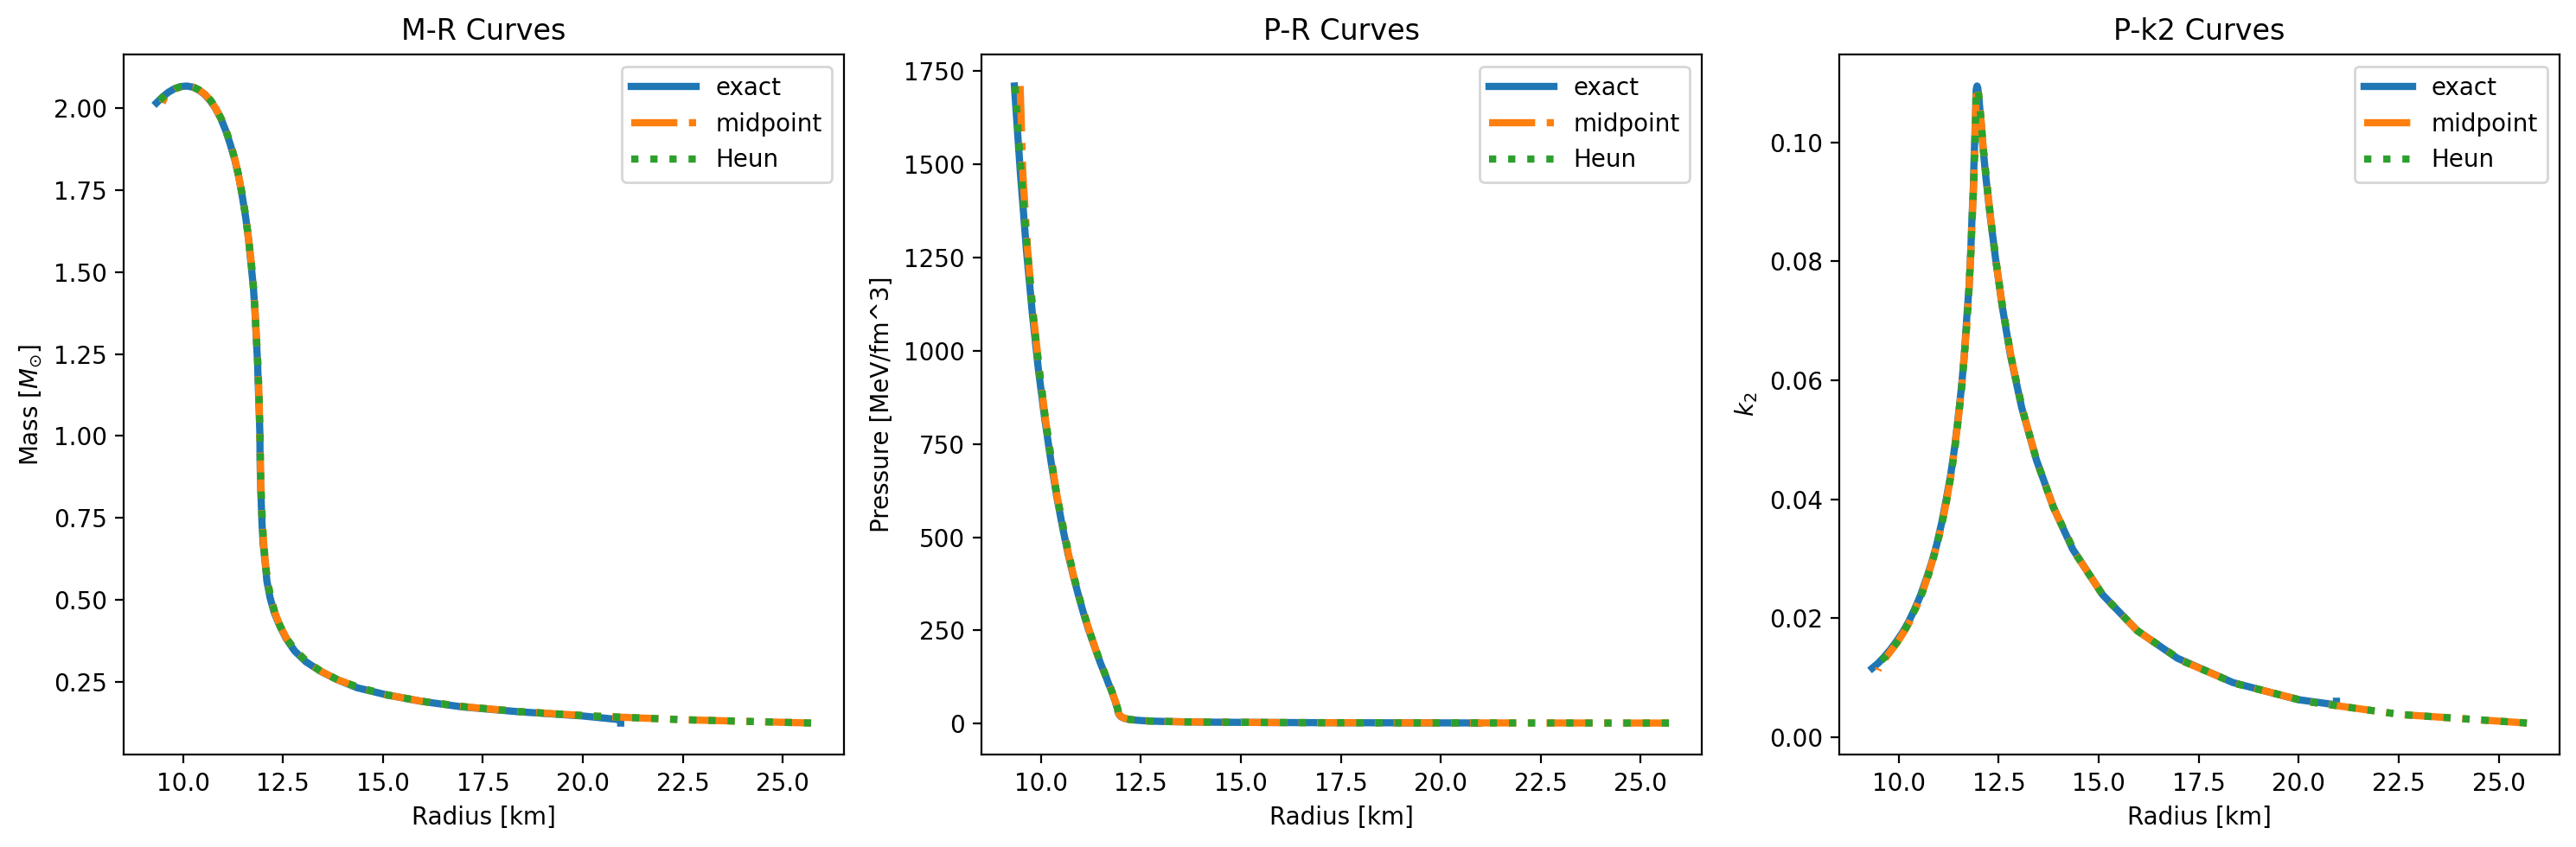

In [62]:
# look at solutions on their own

fig, ax = plt.subplots(1, 3, dpi=200, figsize=(15, 5))

# M-R
ax[0].set_title("M-R Curves")
ax[0].plot(exact_R, exact_M, linewidth=3, label="exact")
ax[0].plot(midpoint_R, midpoint_M, linewidth=3, linestyle="-.", label="midpoint")
ax[0].plot(Heun_R, Heun_M, linewidth=3, linestyle=":", label="Heun")
ax[0].set_xlabel(r"Radius [km]")
ax[0].set_ylabel(r"Mass [$M_{\odot}$]")
ax[0].legend(handlelength=2.7)
plt.legend()

# P-R
ax[1].set_title("P-R Curves")
ax[1].plot(exact_R, exact_P, linewidth=3, label="exact")
ax[1].plot(midpoint_R, midpoint_P, linewidth=3, linestyle="-.", label="midpoint")
ax[1].plot(Heun_R, Heun_P, linewidth=3, linestyle=":", label="Heun")
ax[1].set_xlabel(r"Radius [km]")
ax[1].set_ylabel(r"Pressure [MeV/fm^3]")
ax[1].legend(handlelength=2.7)
plt.legend()

# k2-R
ax[2].set_title("P-k2 Curves")
ax[2].plot(exact_R, exact_k2, linewidth=3, label="exact")
ax[2].plot(midpoint_R, midpoint_k2, linewidth=3, linestyle="-.", label="midpoint")
ax[2].plot(Heun_R, Heun_k2, linewidth=3, linestyle=":", label="Heun")
ax[2].set_xlabel(r"Radius [km]")
ax[2].set_ylabel(r"$k_2$")
ax[2].legend(handlelength=2.7)
plt.legend()

plt.tight_layout()
plt.show()

/var/folders/58/xrmpvhh11mj0pb2kfrznw9qh0000gn/T/ipykernel_85737/1946545912.py:13: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()
/var/folders/58/xrmpvhh11mj0pb2kfrznw9qh0000gn/T/ipykernel_85737/1946545912.py:22: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()
/var/folders/58/xrmpvhh11mj0pb2kfrznw9qh0000gn/T/ipykernel_85737/1946545912.py:31: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


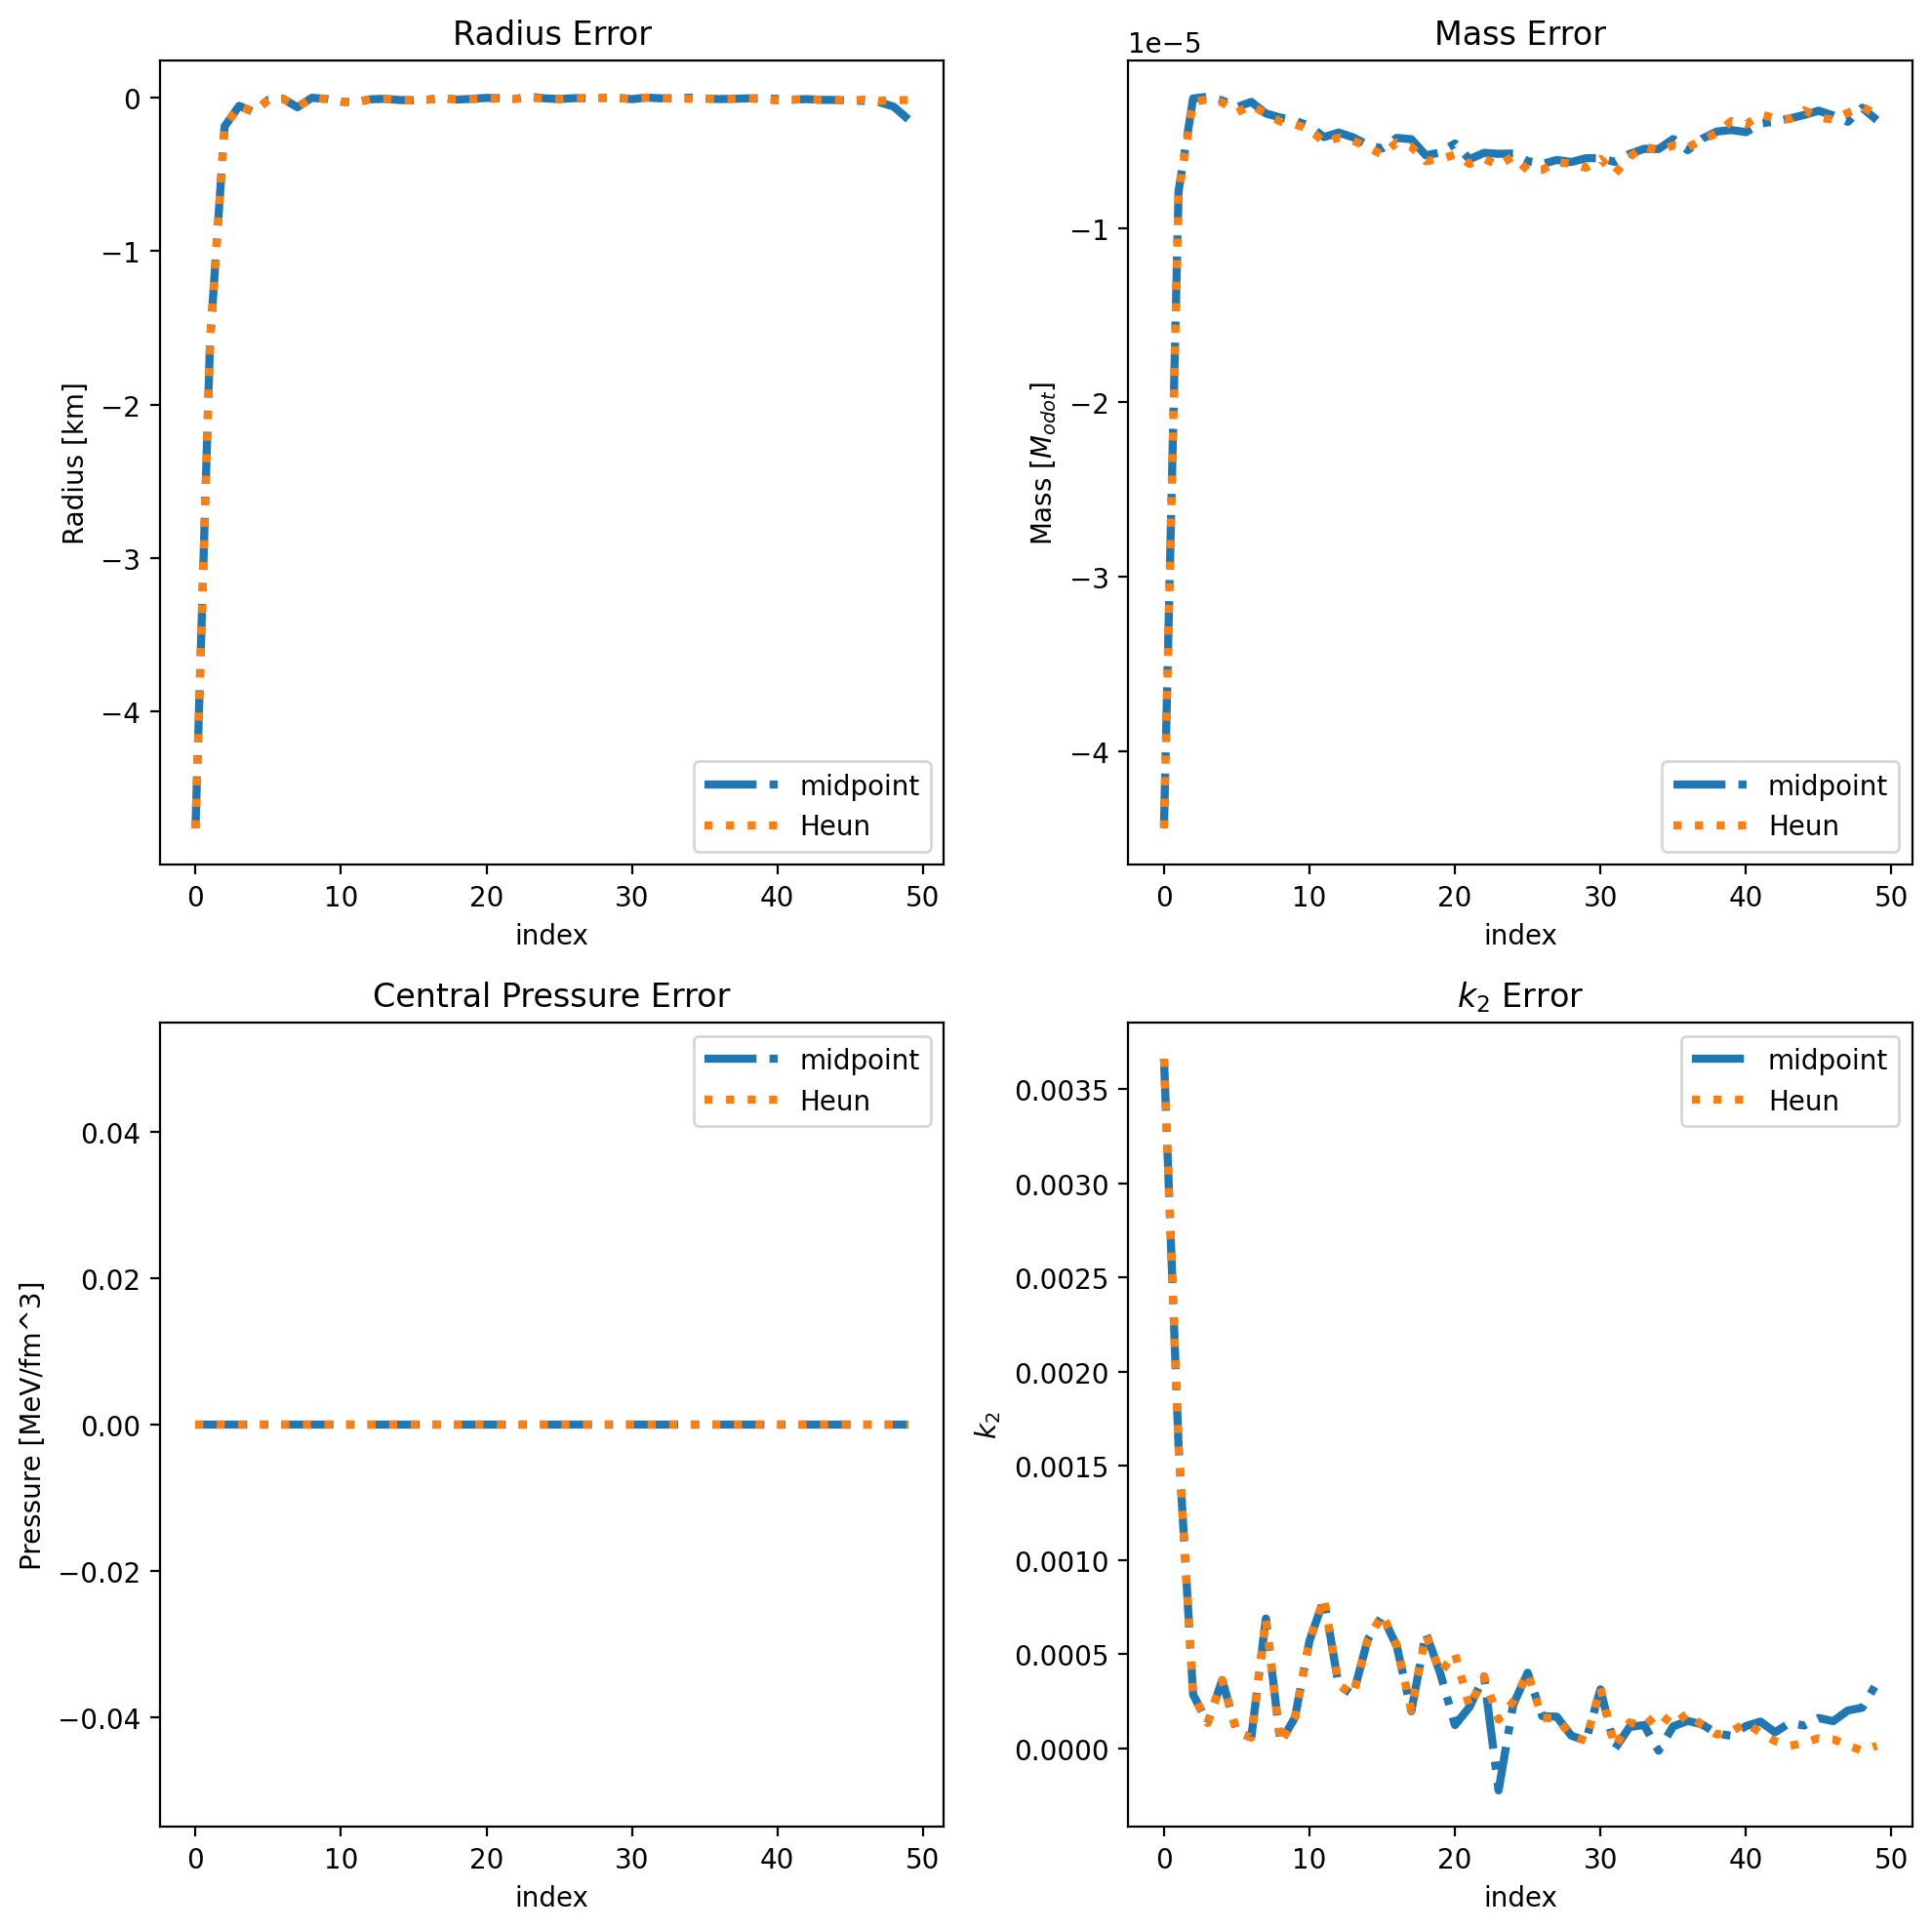

In [64]:
# look at the errors in the two RK2 methods
# look at solutions on their own

fig, ax = plt.subplots(2, 2, dpi=200, figsize=(10, 10))

# Radius
ax[0, 0].set_title("Radius Error")
ax[0, 0].plot(exact_R - midpoint_R, linewidth=3, linestyle="-.", label="midpoint")
ax[0, 0].plot(exact_R - Heun_R, linewidth=3, linestyle=":", label="Heun")
ax[0, 0].set_xlabel("index")
ax[0, 0].set_ylabel(r"Radius [km]")
ax[0, 0].legend(handlelength=2.7)
plt.legend()

# Mass
ax[0, 1].set_title("Mass Error")
ax[0, 1].plot(exact_M - midpoint_M, linewidth=3, linestyle="-.", label="midpoint")
ax[0, 1].plot(exact_M - Heun_M, linewidth=3, linestyle=":", label="Heun")
ax[0, 1].set_xlabel("index")
ax[0, 1].set_ylabel(r"Mass [$M_{odot}$]")
ax[0, 1].legend(handlelength=2.7)
plt.legend()

# Pressure
ax[1, 0].set_title("Central Pressure Error")
ax[1, 0].plot(exact_P - midpoint_P, linewidth=3, linestyle="-.", label="midpoint")
ax[1, 0].plot(exact_P - Heun_P, linewidth=3, linestyle=":", label="Heun")
ax[1, 0].set_xlabel("index")
ax[1, 0].set_ylabel(r"Pressure [MeV/fm^3]")
ax[1, 0].legend(handlelength=2.7)
plt.legend()

# # k2
ax[1, 1].set_title("$k_2$ Error")
ax[1, 1].plot(exact_k2 - midpoint_k2, linewidth=3, linestyle="-.", label="midpoint")
ax[1, 1].plot(exact_k2 - Heun_k2, linewidth=3, linestyle=":", label="Heun")
ax[1, 1].set_xlabel("index")
ax[1, 1].set_ylabel(r"$k_2$")
ax[1, 1].legend(handlelength=2.7)
plt.legend()

plt.tight_layout()
plt.show()